In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.pipeline import Pipeline
from torchsampler import ImbalancedDatasetSampler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import KFold

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


In [ ]:
!pip install torchsampler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_img_paths = pd.read_csv('drive/MyDrive/MURA-v1.1/train_image_paths.csv', header = None, names = ['image_path'])
test_img_paths = pd.read_csv('drive/MyDrive/MURA-v1.1/valid_image_paths.csv', header = None, names = ['image_path'])

In [5]:
def split_img_paths(df):
    temp = df['image_path'].str.split('/', expand=True)
    new_df = pd.DataFrame(df['image_path'])
    new_df['patient_id'] = temp[3]
    new_df['study'] = temp[4].str.split('_', expand = True)[0].str[-1:].astype(int)
    new_df['region'] = temp[2].str.split('_', expand = True)[1]
    map = {'positive':'abnormal', 'negative':'normal'}
    new_df['target'] = temp[4].str.split('_', expand = True)[1]
    new_df['target'] = new_df['target'].map(map)
    #add google drive location to image path
    new_df['image_path'] = 'drive/MyDrive/' + new_df['image_path']
    
    return new_df

In [6]:
mura_train = split_img_paths(train_img_paths)
mura_test = split_img_paths(test_img_paths)

In [7]:
data_transforms = transforms.Compose([
    #
    #note that output channel is 1, will need to change and re-run for use with 3 channels
    #
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [111]:
def class_dict(two_targets):
    classes_2 = ['normal', 'abnormal']
    dict_2 = {'normal' : 0, 'abnormal': 1}
    
    return classes_2, dict_2

In [112]:
class MuraDataset(Dataset):
    # change two targets to False if using 14 target data
    def __init__(self, mura_df, two_targets, transform=data_transforms):
        self.mura = mura_df
        self.transform = transform
        self.classes, self.class_to_idx = class_dict(two_targets=two_targets)
        self.label= mura_df['target'].map({'normal' : 0, 'abnormal': 1})

    def __len__(self):
        return len(self.mura)

    # retrives image from path in df file and target from df
    def get_image_class(self, index):
        image_path = self.mura.iloc[index]['image_path']
        class_name = self.mura.iloc[index]['target']
        return Image.open(image_path), class_name  

    def get_labels(self):
        return self.label


    def __getitem__(self, idx):
        image, class_name = self.get_image_class(idx)
        label = self.class_to_idx[class_name]

        return self.transform(image), label

In [113]:
def training(model, model_name, num_epochs, train_dataloader, test_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    test_loss_array = []
    test_acc_array = []
    lowest_test_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in test_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                test_loss_array.append(epoch_loss / epoch_items)
                test_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_test_loss:
                    lowest_test_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest test loss for {}: {}".format(model_name, lowest_test_loss))

    return best_model, train_loss_array, train_acc_array, test_loss_array, test_acc_array

## **Forearm**

In [115]:
forearm_train = mura_train[mura_train['region']=='FOREARM']
forearm_test = mura_test[mura_test['region']=='FOREARM']

In [116]:
pd.set_option('max_colwidth', None)
forearm_train.head()

,image_path,patient_id,study,region,target
29440,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient09083/study1_positive/image1.png,patient09083,1,FOREARM,abnormal
29441,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient09083/study1_positive/image2.png,patient09083,1,FOREARM,abnormal
29442,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient05601/study1_positive/image1.png,patient05601,1,FOREARM,abnormal
29443,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient05601/study1_positive/image2.png,patient05601,1,FOREARM,abnormal
29444,drive/MyDrive/MURA-v1.1/train/XR_FOREARM/patient05601/study1_positive/image3.png,patient05601,1,FOREARM,abnormal


In [117]:
forearm_train_dataset = MuraDataset(mura_df = forearm_train, two_targets=True)
forearm_test_dataset = MuraDataset(mura_df = forearm_test, two_targets=True)

In [119]:
Forearm_train_dataloader = DataLoader(forearm_train_dataset, sampler=ImbalancedDatasetSampler(forearm_train_dataset), batch_size=64)
Forearm_test_dataloader = DataLoader(forearm_test_dataset,  batch_size=64, shuffle=True)
num_epochs = 15


In [120]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_Forearm_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Forearm_train_dataloader,
                                        test_dataloader=Forearm_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_Forearm_training

forearm_min_loss = min(test_loss_array)
forearm_min_loss_epoch = test_loss_array.index(forearm_min_loss)
forearm_min_loss_accuracy = test_acc_array[forearm_min_loss_epoch]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [10:32<2:27:32, 632.34s/it]

	| New lowest test loss for DenseNet161: 0.013627686175793113
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [13:17<1:17:24, 357.27s/it]

	| New lowest test loss for DenseNet161: 0.01127905901088271
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [14:36<46:03, 230.33s/it]  

	| New lowest test loss for DenseNet161: 0.010605540188444017
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [15:29<29:22, 160.19s/it]

	| New lowest test loss for DenseNet161: 0.010452817642807564
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [16:10<19:32, 117.22s/it]

	| New lowest test loss for DenseNet161: 0.010286787419620146
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [16:47<13:32, 90.24s/it] 

	| New lowest test loss for DenseNet161: 0.010153811833391159
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [17:23<09:38, 72.27s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [17:57<07:01, 60.18s/it]

	| New lowest test loss for DenseNet161: 0.010036889698814316
Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [18:31<05:12, 52.04s/it]

Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [19:05<03:52, 46.45s/it]

	| New lowest test loss for DenseNet161: 0.01001693679644816
Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [19:39<02:50, 42.68s/it]

	| New lowest test loss for DenseNet161: 0.009964464114749947
Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [20:12<01:59, 39.77s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [20:46<01:15, 37.88s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [21:20<00:36, 36.63s/it]

	| New lowest test loss for DenseNet161: 0.009958966427863238
Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [21:53<00:00, 87.59s/it]


In [121]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(forearm_min_loss, forearm_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(forearm_min_loss_accuracy))


Training results:
	Min test loss 0.0100 was achieved during epoch #14
	 test accuracy during min test loss is 0.7143


In [122]:
#predictions on Test data

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(Forearm_test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames= forearm_test['image_path'].values.tolist()

def class_dict_inverse(two_targets):
    if two_targets==0:
      return 'normal'
    else:
      return 'abnormal'

all_preds_decoded = [class_dict_inverse(i) for i in all_preds]

submission_forearm_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_forearm_df.to_csv('test_predictions_forearm.csv', header=False, index=False) 
submission_forearm_df

100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


,File,Prediction
0,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11392/study1_positive/image1.png,normal
1,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11392/study1_positive/image2.png,abnormal
2,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11392/study1_positive/image3.png,normal
3,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11393/study1_positive/image1.png,abnormal
4,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11393/study1_positive/image2.png,normal
...,...,...
296,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11191/study1_negative/image1.png,abnormal
297,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11191/study1_negative/image2.png,normal
298,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11191/study1_negative/image3.png,abnormal
299,drive/MyDrive/MURA-v1.1/valid/XR_FOREARM/patient11496/study1_negative/image1.png,abnormal


## **Finger**

In [136]:
finger_train = mura_train[mura_train['region']=='FINGER']
finger_test = mura_test[mura_test['region']=='FINGER']

In [137]:
finger_train_dataset = MuraDataset(mura_df = finger_train, two_targets=True)
finger_test_dataset = MuraDataset(mura_df = finger_test, two_targets=True)

In [138]:
Finger_train_dataloader = DataLoader(finger_train_dataset, sampler=ImbalancedDatasetSampler(finger_train_dataset),batch_size=64 )
Finger_test_dataloader = DataLoader(finger_test_dataset,  batch_size=64, shuffle=True)
num_epochs = 15


In [139]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_finger_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Finger_train_dataloader,
                                        test_dataloader=Finger_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_finger_training

finger_min_loss = min(test_loss_array)
finger_min_loss_epoch = test_loss_array.index(finger_min_loss)
finger_min_loss_accuracy = test_acc_array[finger_min_loss_epoch]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [33:21<7:47:03, 2001.69s/it]

	| New lowest test loss for DenseNet161: 0.011034523716717636
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [40:40<3:54:32, 1082.53s/it]

	| New lowest test loss for DenseNet161: 0.010208352527494286
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [44:33<2:18:52, 694.38s/it] 

	| New lowest test loss for DenseNet161: 0.009816593823877694
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [46:51<1:27:03, 474.89s/it]

Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [48:40<57:09, 342.95s/it]  

	| New lowest test loss for DenseNet161: 0.009465232976346626
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [50:18<38:56, 259.64s/it]

	| New lowest test loss for DenseNet161: 0.009330598754634567
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [51:49<27:16, 204.51s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [53:16<19:30, 167.20s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [54:44<14:12, 142.15s/it]

Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [56:10<10:25, 125.03s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [57:36<07:32, 113.15s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [59:03<05:14, 104.95s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [1:00:29<03:18, 99.20s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [1:01:54<01:34, 94.98s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [1:03:19<00:00, 253.31s/it]


In [140]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(finger_min_loss, finger_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(finger_min_loss_accuracy))


Training results:
	Min test loss 0.0093 was achieved during epoch #6
	 test accuracy during min test loss is 0.7375


In [141]:
#predictions on Test data

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(Finger_test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames= finger_test['image_path'].values.tolist()

def class_dict_inverse(two_targets):
    if two_targets==0:
      return 'normal'
    else:
      return 'abnormal'

all_preds_decoded = [class_dict_inverse(i) for i in all_preds]

submission_finger_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_finger_df.to_csv('test_predictions_finger.csv', header=False, index=False) 
submission_finger_df

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


,File,Prediction
0,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11882/study1_positive/image1.png,abnormal
1,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11882/study1_positive/image2.png,normal
2,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11883/study1_positive/image1.png,normal
3,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11883/study1_positive/image2.png,abnormal
4,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11883/study1_positive/image3.png,abnormal
...,...,...
456,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image3.png,abnormal
457,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image4.png,abnormal
458,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image1.png,normal
459,drive/MyDrive/MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image2.png,abnormal


## **Hand**

In [142]:
hand_train = mura_train[mura_train['region']=='HAND']
hand_test = mura_test[mura_test['region']=='HAND']

In [143]:
hand_train_dataset = MuraDataset(mura_df = hand_train, two_targets=True)
hand_test_dataset = MuraDataset(mura_df = hand_test, two_targets=True)

In [144]:
hand_train_dataloader = DataLoader(hand_train_dataset, sampler=ImbalancedDatasetSampler(hand_train_dataset), batch_size=64)
hand_test_dataloader = DataLoader(hand_test_dataset,  batch_size=64, shuffle=True)
num_epochs = 15


In [145]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_hand_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=hand_train_dataloader,
                                        test_dataloader=hand_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_hand_training

hand_min_loss = min(test_loss_array)
hand_min_loss_epoch = test_loss_array.index(hand_min_loss)
hand_min_loss_accuracy = test_acc_array[hand_min_loss_epoch]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [34:30<8:03:03, 2070.22s/it]

	| New lowest test loss for DenseNet161: 0.011660009363423223
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [42:09<4:03:16, 1122.81s/it]

	| New lowest test loss for DenseNet161: 0.011105614900588989
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [45:58<2:22:54, 714.51s/it] 

	| New lowest test loss for DenseNet161: 0.010481530298357425
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [48:38<1:30:51, 495.56s/it]

Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [50:42<1:00:16, 361.69s/it]

	| New lowest test loss for DenseNet161: 0.010324247505353846
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [52:32<41:25, 276.14s/it]  

	| New lowest test loss for DenseNet161: 0.010208509797635285
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [54:16<29:18, 219.78s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [55:56<21:11, 181.63s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [57:34<15:32, 155.39s/it]

Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [59:10<11:25, 137.04s/it]

	| New lowest test loss for DenseNet161: 0.010196938333304033
Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [1:00:47<08:19, 124.81s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [1:02:22<05:47, 115.97s/it]

	| New lowest test loss for DenseNet161: 0.010123360545738884
Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [1:03:58<03:39, 109.82s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [1:05:34<01:45, 105.71s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [1:07:10<00:00, 268.67s/it]

	| New lowest test loss for DenseNet161: 0.010091900177623915


In [146]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(hand_min_loss, hand_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(hand_min_loss_accuracy))


Training results:
	Min test loss 0.0101 was achieved during epoch #15
	 test accuracy during min test loss is 0.7065


In [147]:
#predictions on Test data

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(hand_test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames= hand_test['image_path'].values.tolist()

def class_dict_inverse(two_targets):
    if two_targets==0:
      return 'normal'
    else:
      return 'abnormal'

all_preds_decoded = [class_dict_inverse(i) for i in all_preds]

submission_hand_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_hand_df.to_csv('test_predictions_hand.csv', header=False, index=False) 
submission_hand_df.head(10)

100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


,File,Prediction
0,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11497/study1_positive/image1.png,abnormal
1,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11497/study1_positive/image2.png,abnormal
2,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11497/study1_positive/image3.png,normal
3,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11498/study1_positive/image1.png,abnormal
4,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11498/study1_positive/image2.png,abnormal
5,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11498/study1_positive/image3.png,abnormal
6,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11499/study1_positive/image1.png,normal
7,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11499/study1_positive/image2.png,normal
8,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11499/study1_positive/image3.png,normal
9,drive/MyDrive/MURA-v1.1/valid/XR_HAND/patient11500/study1_positive/image1.png,abnormal


## **Wrist**

In [148]:
wrist_train = mura_train[mura_train['region']=='WRIST']
wrist_test = mura_test[mura_test['region']=='WRIST']

In [149]:
wrist_train_dataset = MuraDataset(mura_df = wrist_train, two_targets=True)
wrist_test_dataset = MuraDataset(mura_df = wrist_test, two_targets=True)

In [150]:
Wrist_train_dataloader = DataLoader(wrist_train_dataset, sampler=ImbalancedDatasetSampler(wrist_train_dataset), batch_size=64)
Wrist_test_dataloader = DataLoader(wrist_test_dataset, batch_size=64, shuffle=False)
num_epochs = 15

In [153]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_Wrist_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Wrist_train_dataloader,
                                        test_dataloader=Wrist_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_Wrist_training

wrist_min_loss = min(test_loss_array)
wrist_min_loss_epoch = test_loss_array.index(wrist_min_loss)
wrist_min_loss_accuracy = test_acc_array[wrist_min_loss_epoch]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [02:45<38:34, 165.35s/it]

	| New lowest test loss for DenseNet161: 0.009775458997587513
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [05:29<35:44, 164.94s/it]

	| New lowest test loss for DenseNet161: 0.00882393239300602
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [08:14<32:57, 164.79s/it]

	| New lowest test loss for DenseNet161: 0.008499352586468362
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [10:59<30:11, 164.69s/it]

	| New lowest test loss for DenseNet161: 0.00834200930342146
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [13:43<27:26, 164.62s/it]

	| New lowest test loss for DenseNet161: 0.008163093344756431
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [16:28<24:41, 164.58s/it]

Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [19:13<21:57, 164.69s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [21:55<19:08, 164.04s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [24:38<16:21, 163.57s/it]

	| New lowest test loss for DenseNet161: 0.008059408487427035
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [27:20<13:36, 163.30s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [30:03<10:52, 163.22s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [32:46<08:08, 162.95s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [35:28<05:25, 162.72s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [38:09<02:42, 162.32s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [40:52<00:00, 163.51s/it]


In [154]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(wrist_min_loss, wrist_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(wrist_min_loss_accuracy))


Training results:
	Min test loss 0.0081 was achieved during epoch #9
	 test accuracy during min test loss is 0.7618


In [156]:
#predictions on Test data

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(Wrist_test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames= wrist_test['image_path'].values.tolist()

def class_dict_inverse(two_targets):
    if two_targets==0:
      return 'normal'
    else:
      return 'abnormal'

all_preds_decoded = [class_dict_inverse(i) for i in all_preds]

submission_wrist_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_wrist_df.to_csv('test_predictions_wrist.csv', header=False, index=False) 
submission_wrist_df.head(10)

100%|██████████| 11/11 [00:13<00:00,  1.18s/it]


,File,Prediction
0,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,abnormal
1,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,abnormal
2,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,abnormal
3,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,normal
4,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,abnormal
5,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image2.png,abnormal
6,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/image1.png,abnormal
7,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/image2.png,abnormal
8,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/image3.png,abnormal
9,drive/MyDrive/MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/image1.png,normal


## **Humerus**

In [157]:
humerus_train = mura_train[mura_train['region']=='HUMERUS']
humerus_test = mura_test[mura_test['region']=='HUMERUS']

In [158]:
humerus_train_dataset = MuraDataset(mura_df = humerus_train, two_targets=True)
humerus_test_dataset = MuraDataset(mura_df = humerus_test, two_targets=True)

In [159]:
Humerus_train_dataloader = DataLoader(humerus_train_dataset, sampler=ImbalancedDatasetSampler(humerus_train_dataset), batch_size=64)
Humerus_test_dataloader = DataLoader(humerus_test_dataset, batch_size=64, shuffle=False)
num_epochs = 15

In [160]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_humerus_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Humerus_train_dataloader,
                                        test_dataloader=Humerus_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_humerus_training

humerus_min_loss = min(test_loss_array)
humerus_min_loss_epoch = test_loss_array.index(humerus_min_loss)
humerus_min_loss_accuracy = test_acc_array[humerus_min_loss_epoch]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [10:52<2:32:11, 652.28s/it]

	| New lowest test loss for DenseNet161: 0.021826416667964723
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [12:53<1:13:40, 340.01s/it]

	| New lowest test loss for DenseNet161: 0.012944387892882029
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [13:47<41:53, 209.43s/it]  

	| New lowest test loss for DenseNet161: 0.012011402803990576
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [14:22<25:43, 140.31s/it]

	| New lowest test loss for DenseNet161: 0.01182068780892425
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [14:49<16:34, 99.43s/it] 

	| New lowest test loss for DenseNet161: 0.011391741947995292
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [15:15<11:12, 74.69s/it]

	| New lowest test loss for DenseNet161: 0.011227793370683989
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [15:41<07:50, 58.78s/it]

	| New lowest test loss for DenseNet161: 0.011186177117957009
Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [16:06<05:36, 48.07s/it]

	| New lowest test loss for DenseNet161: 0.011157885607745912
Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [16:33<04:07, 41.28s/it]

	| New lowest test loss for DenseNet161: 0.011079309094283316
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [16:58<03:01, 36.33s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [17:23<02:11, 33.00s/it]

	| New lowest test loss for DenseNet161: 0.011054235200087229
Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [17:49<01:32, 30.82s/it]

	| New lowest test loss for DenseNet161: 0.011016558234890303
Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [18:15<00:58, 29.25s/it]

	| New lowest test loss for DenseNet161: 0.010995697644021776
Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [18:40<00:28, 28.06s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [19:06<00:00, 76.40s/it]

	| New lowest test loss for DenseNet161: 0.01098247617483139


In [161]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(humerus_min_loss, humerus_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(humerus_min_loss_accuracy))


Training results:
	Min test loss 0.0110 was achieved during epoch #15
	 test accuracy during min test loss is 0.6875


In [162]:
#predictions on Test data

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(Wrist_test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames= humerus_test['image_path'].values.tolist()

def class_dict_inverse(two_targets):
    if two_targets==0:
      return 'normal'
    else:
      return 'abnormal'

all_preds_decoded = [class_dict_inverse(i) for i in all_preds]

submission_humerus_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_humerus_df.to_csv('test_predictions_humerus.csv', header=False, index=False) 
submission_humerus_df.head(10)

100%|██████████| 11/11 [00:10<00:00,  1.00it/s]


,File,Prediction
0,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11608/study1_positive/image1.png,abnormal
1,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11608/study1_positive/image2.png,normal
2,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11214/study1_positive/image1.png,normal
3,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11214/study1_positive/image2.png,abnormal
4,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11609/study1_positive/image1.png,abnormal
5,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11610/study1_positive/image1.png,abnormal
6,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11610/study1_positive/image2.png,abnormal
7,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11611/study1_positive/image1.png,abnormal
8,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11611/study1_positive/image2.png,abnormal
9,drive/MyDrive/MURA-v1.1/valid/XR_HUMERUS/patient11391/study1_positive/image1.png,normal


## **Shoulder**

In [173]:
shoulder_train = mura_train[mura_train['region']=='SHOULDER']
shoulder_test = mura_test[mura_test['region']=='SHOULDER']

In [174]:
shoulder_train_dataset = MuraDataset(mura_df = shoulder_train, two_targets=True)
shoulder_test_dataset = MuraDataset(mura_df = shoulder_test, two_targets=True)

In [175]:
Shoulder_train_dataloader = DataLoader(shoulder_train_dataset, sampler=ImbalancedDatasetSampler(shoulder_train_dataset), batch_size=64)
Shoulder_test_dataloader = DataLoader(shoulder_test_dataset,  batch_size=64, shuffle=False)
num_epochs = 15


In [177]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_shoulder_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Shoulder_train_dataloader,
                                        test_dataloader=Shoulder_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_shoulder_training

shoulder_min_loss = min(test_loss_array)
shoulder_min_loss_epoch = test_loss_array.index(shoulder_min_loss)
shoulder_min_loss_accuracy = test_acc_array[shoulder_min_loss_epoch]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [02:19<32:32, 139.47s/it]

	| New lowest test loss for DenseNet161: 0.010469994261252096
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [04:39<30:14, 139.56s/it]

	| New lowest test loss for DenseNet161: 0.009817702467445793
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [06:58<27:55, 139.63s/it]

	| New lowest test loss for DenseNet161: 0.009282436135818861
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [09:17<25:32, 139.33s/it]

	| New lowest test loss for DenseNet161: 0.009159605837630548
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [11:37<23:13, 139.36s/it]

	| New lowest test loss for DenseNet161: 0.009084388957777413
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [13:57<20:56, 139.62s/it]

	| New lowest test loss for DenseNet161: 0.009007705782488861
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [16:17<18:38, 139.77s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [18:37<16:18, 139.79s/it]

	| New lowest test loss for DenseNet161: 0.008938820916848327
Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [20:56<13:58, 139.67s/it]

Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [23:22<11:48, 141.63s/it]

	| New lowest test loss for DenseNet161: 0.00890426107452352
Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [25:44<09:26, 141.71s/it]

	| New lowest test loss for DenseNet161: 0.00888809201772429
Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [28:04<07:03, 141.29s/it]

	| New lowest test loss for DenseNet161: 0.00887139721196244
Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [30:39<04:50, 145.22s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [32:59<02:23, 143.70s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [35:18<00:00, 141.20s/it]


In [178]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(shoulder_min_loss, shoulder_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(shoulder_min_loss_accuracy))


Training results:
	Min test loss 0.0089 was achieved during epoch #12
	 test accuracy during min test loss is 0.7371


In [180]:
#predictions on Test data

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(Shoulder_test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames= shoulder_test['image_path'].values.tolist()

def class_dict_inverse(two_targets):
    if two_targets==0:
      return 'normal'
    else:
      return 'abnormal'

all_preds_decoded = [class_dict_inverse(i) for i in all_preds]

submission_shoulder_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_shoulder_df.to_csv('test_predictions_shoulder.csv', header=False, index=False) 
submission_shoulder_df.head(10)

100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


,File,Prediction
0,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11676/study1_positive/image1.png,abnormal
1,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11676/study1_positive/image2.png,abnormal
2,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11676/study1_positive/image3.png,normal
3,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11703/study1_positive/image1.png,abnormal
4,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11703/study1_positive/image2.png,normal
5,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11344/study1_positive/image1.png,abnormal
6,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11344/study1_positive/image2.png,normal
7,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11344/study1_positive/image3.png,normal
8,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11344/study1_positive/image4.png,normal
9,drive/MyDrive/MURA-v1.1/valid/XR_SHOULDER/patient11281/study1_positive/image1.png,normal


## **Elbow**

In [181]:
elbow_train = mura_train[mura_train['region']=='ELBOW']
elbow_test = mura_test[mura_test['region']=='ELBOW']

In [182]:
elbow_train_dataset = MuraDataset(mura_df = elbow_train, two_targets=True)
elbow_test_dataset = MuraDataset(mura_df = elbow_test, two_targets=True)

In [183]:
Elbow_train_dataloader = DataLoader(elbow_train_dataset, sampler= ImbalancedDatasetSampler(elbow_train_dataset), batch_size= 64)
Elbow_test_dataloader = DataLoader(elbow_test_dataset, batch_size= 64, shuffle= True)
num_epochs = 15

In [184]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)


densenet161_elbow_training = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=Elbow_train_dataloader,
                                        test_dataloader=Elbow_test_dataloader)

model_densenet161, train_loss_array, train_acc_array, test_loss_array, test_acc_array = densenet161_elbow_training

elbow_min_loss = min(test_loss_array)
elbow_min_loss_epoch = test_loss_array.index(elbow_min_loss)
elbow_min_loss_accuracy = test_acc_array[elbow_min_loss_epoch]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [31:00<7:14:04, 1860.29s/it]

	| New lowest test loss for DenseNet161: 0.011399463812510172
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [37:44<3:37:28, 1003.71s/it]

	| New lowest test loss for DenseNet161: 0.010155708943643878
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [40:46<2:05:41, 628.45s/it] 

	| New lowest test loss for DenseNet161: 0.009500269095102947
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [42:48<1:18:35, 428.70s/it]

	| New lowest test loss for DenseNet161: 0.00937691875683364
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [44:24<51:27, 308.78s/it]  

	| New lowest test loss for DenseNet161: 0.009159146713954146
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [45:52<35:03, 233.73s/it]

	| New lowest test loss for DenseNet161: 0.00904785022940687
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [47:16<24:38, 184.75s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [48:40<17:47, 152.57s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [50:03<13:05, 130.83s/it]

	| New lowest test loss for DenseNet161: 0.00887436879578457
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [51:27<09:41, 116.23s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [52:49<07:03, 105.90s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [54:12<04:56, 98.80s/it] 

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [55:34<03:07, 93.76s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [56:57<01:30, 90.49s/it]

	| New lowest test loss for DenseNet161: 0.008821613942423175
Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [58:19<00:00, 233.33s/it]


In [185]:
print("\nTraining results:")
print("\tMin test loss {:.4f} was achieved during epoch #{}".format(elbow_min_loss, elbow_min_loss_epoch + 1))
print("\t test accuracy during min test loss is {:.4f}".format(elbow_min_loss_accuracy))


Training results:
	Min test loss 0.0088 was achieved during epoch #14
	 test accuracy during min test loss is 0.7656


In [187]:
#predictions on Test data

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(Elbow_test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames= elbow_test['image_path'].values.tolist()

def class_dict_inverse(two_targets):
    if two_targets==0:
      return 'normal'
    else:
      return 'abnormal'

all_preds_decoded = [class_dict_inverse(i) for i in all_preds]

submission_elbow_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_elbow_df.to_csv('test_predictions_elbow.csv', header=False, index=False) 
submission_elbow_df.head(10)

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


,File,Prediction
0,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11659/study1_positive/image1.png,normal
1,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11659/study1_positive/image2.png,abnormal
2,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11659/study1_positive/image3.png,normal
3,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11802/study1_positive/image1.png,normal
4,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11802/study1_positive/image2.png,abnormal
5,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11802/study1_positive/image3.png,abnormal
6,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11802/study1_positive/image4.png,abnormal
7,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11802/study1_positive/image5.png,normal
8,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11803/study1_positive/image1.png,abnormal
9,drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11803/study1_positive/image2.png,normal


In [188]:
#Training & Test visuals

def visualize_training_results(train_loss_array,
                               test_loss_array,
                               train_acc_array,
                               test_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), test_loss_array, label="test_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), test_acc_array, label="test_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

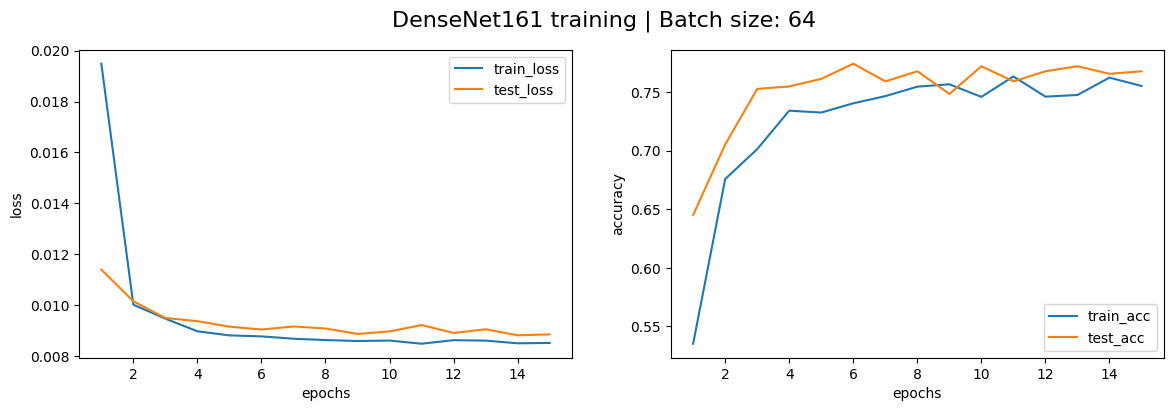

In [189]:
visualize_training_results(train_loss_array,
                           test_loss_array,
                           train_acc_array,
                           test_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)